In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
!wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/edges2shoes.tar.gz

!tar -xvf edges2shoes.tar.gz

Streaming output truncated to the last 5000 lines.
edges2shoes/train/46383_AB.jpg
edges2shoes/train/46384_AB.jpg
edges2shoes/train/46385_AB.jpg
edges2shoes/train/46386_AB.jpg
edges2shoes/train/46387_AB.jpg
edges2shoes/train/46388_AB.jpg
edges2shoes/train/46389_AB.jpg
edges2shoes/train/4638_AB.jpg
edges2shoes/train/46390_AB.jpg
edges2shoes/train/46391_AB.jpg
edges2shoes/train/46392_AB.jpg
edges2shoes/train/449_AB.jpg
edges2shoes/train/44_AB.jpg
edges2shoes/train/45000_AB.jpg
edges2shoes/train/45001_AB.jpg
edges2shoes/train/45002_AB.jpg
edges2shoes/train/45003_AB.jpg
edges2shoes/train/45004_AB.jpg
edges2shoes/train/45005_AB.jpg
edges2shoes/train/45006_AB.jpg
edges2shoes/train/45007_AB.jpg
edges2shoes/train/45008_AB.jpg
edges2shoes/train/45009_AB.jpg
edges2shoes/train/4500_AB.jpg
edges2shoes/train/45010_AB.jpg
edges2shoes/train/45011_AB.jpg
edges2shoes/train/45012_AB.jpg
edges2shoes/train/45013_AB.jpg
edges2shoes/train/45687_AB.jpg
edges2shoes/train/45688_AB.jpg
edges2shoes/train/45689_AB

In [ ]:
#Constants
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_HEIGHT = 256
IMG_WIDTH = 256
OUTPUT_CHANNELS = 3
PATH = "/content/edges2shoes/"

In [ ]:
#Util functions
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  src_image = image[:, :w, :]
  tar_image = image[:, w:, :]

  src_image = tf.cast(src_image, tf.float32)
  tar_image = tf.cast(tar_image, tf.float32)

  return src_image, tar_image

In [ ]:
def resize(in_img, out_img, height, width):
  src_image = tf.image.resize(in_img, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  tar_image = tf.image.resize(out_img, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return src_image, tar_image

In [ ]:
def random_crop(src_image, tar_image):
  stacked_image = tf.stack([src_image, tar_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

def normalize(src_image, tar_image):
  src_image = (src_image / 127.5) - 1
  tar_image = (tar_image / 127.5) - 1

  return src_image, tar_image

#TF Helper Functions
@tf.function()
def random_jitter(src_image, tar_image):

  src_image, tar_image = resize(src_image, tar_image, 286, 286)
  src_image, tar_image = random_crop(src_image, tar_image)

  if tf.random.uniform(()) > 0.5:

    src_image = tf.image.flip_left_right(src_image)
    tar_image = tf.image.flip_left_right(tar_image)

  return src_image, tar_image

In [ ]:
def load_image_train(image_file):
  src_image, tar_image = load(image_file)
  src_image, tar_image = random_jitter(src_image, tar_image)
  src_image, tar_image = normalize(src_image, tar_image)

  return src_image, tar_image

def load_image_test(image_file):
  src_image, tar_image = load(image_file)
  src_image, tar_image = resize(src_image, tar_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  src_image, tar_image = normalize(src_image, tar_image)

  return src_image, tar_image

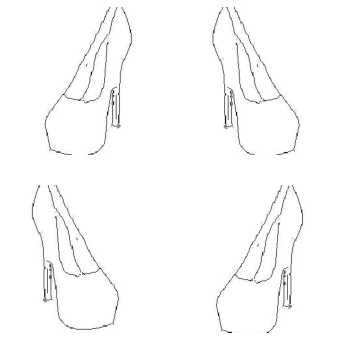

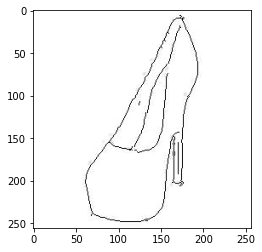

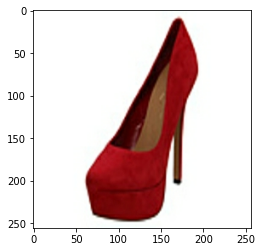

In [ ]:
inp, re = load(PATH+'train/8606_AB.jpg')

plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

inp, re = load(PATH+'train/8606_AB.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [ ]:
#Making all of the datasets using helpful tf.data module

train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

#print(len(train_dataset))

In [ ]:
def gendisc_downunit(filters, size, apply_batchnorm=True):
    init = tf.random_uniform_initializer(0., 0.02)
    
    gen_block = tf.keras.Sequential()
    gen_block.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='SAME', kernel_initializer=init, use_bias=False))

    if apply_batchnorm:
        gen_block.add(tf.keras.layers.BatchNormalization())

    gen_block.add(tf.keras.layers.LeakyReLU())

    return gen_block

down_model = gendisc_downunit(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print(down_result.shape)


(1, 128, 128, 3)


In [ ]:
def gendisc_upunit(filters, size, apply_dropout=True):
    init = tf.random_uniform_initializer(0., 0.02)

    gen_block = tf.keras.Sequential()
    gen_block.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding="SAME",kernel_initializer=init, use_bias=False))
    gen_block.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        gen_block.add(tf.keras.layers.Dropout(0.5))

    gen_block.add(tf.keras.layers.ReLU())

    return gen_block

up_model = gendisc_upunit(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


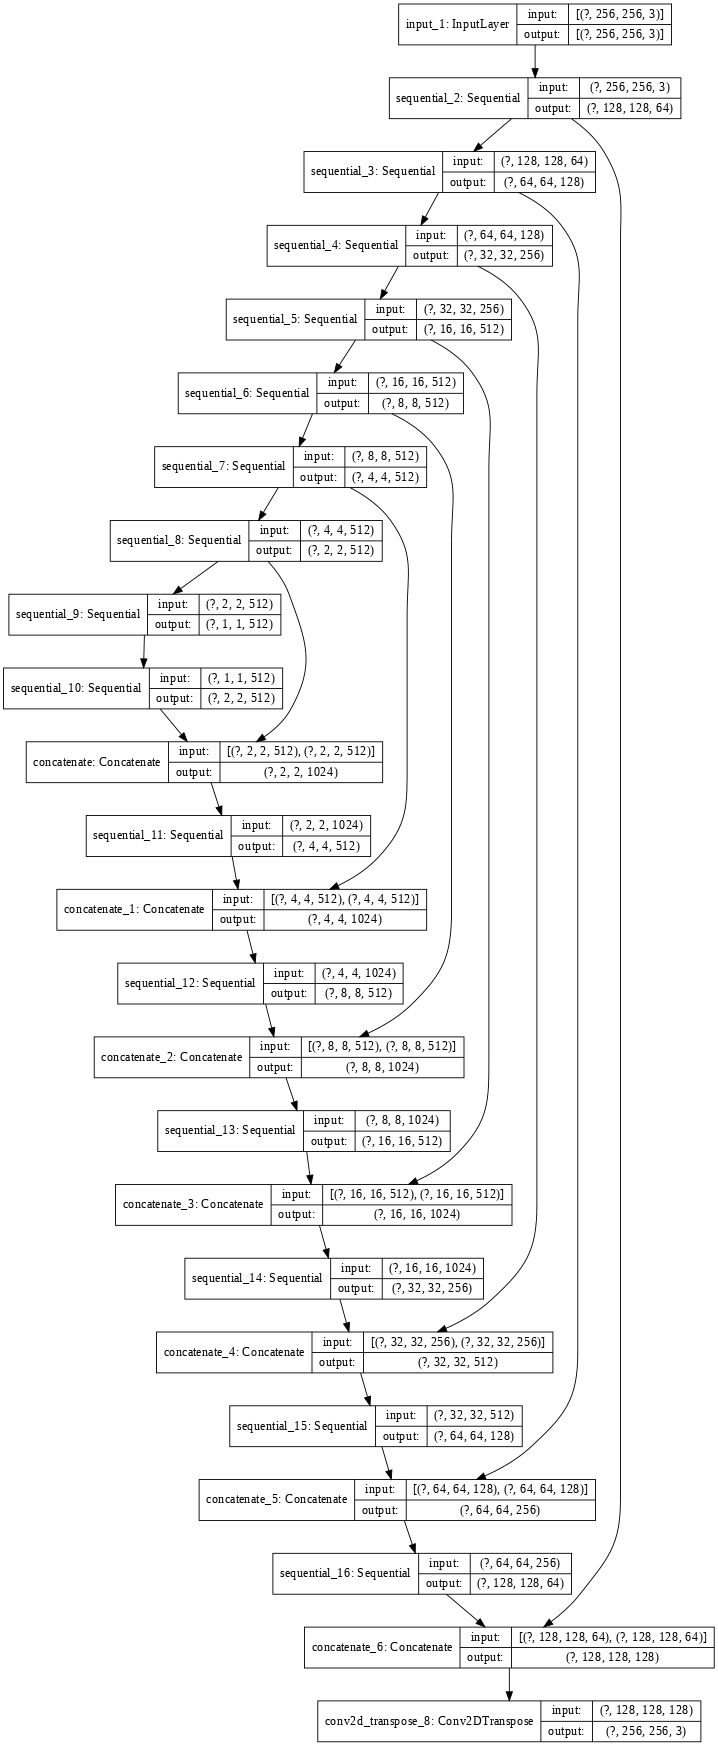

In [ ]:
def Generator():
    inputs = tf.keras.layers.Input([256, 256, 3])

    down_stack = [
                  
    gendisc_downunit(64, 4, apply_batchnorm=False),
    gendisc_downunit(128, 4),
    gendisc_downunit(256, 4),
    gendisc_downunit(512, 4),
    gendisc_downunit(512, 4),
    gendisc_downunit(512, 4),
    gendisc_downunit(512, 4),
    gendisc_downunit(512, 4),

    ]

    up_stack = [
               
    gendisc_upunit(512, 4, apply_dropout=True),
    gendisc_upunit(512, 4, apply_dropout=True),
    gendisc_upunit(512, 4, apply_dropout=True),
    gendisc_upunit(512, 4),
    gendisc_upunit(256, 4),
    gendisc_upunit(128, 4),
    gendisc_upunit(64, 4),

    ]

    init = tf.random_uniform_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding="SAME", kernel_initializer=init, activation='tanh')

    x = inputs

    skips = []

    for downsample in down_stack:
        x = downsample(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)

    return model

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss



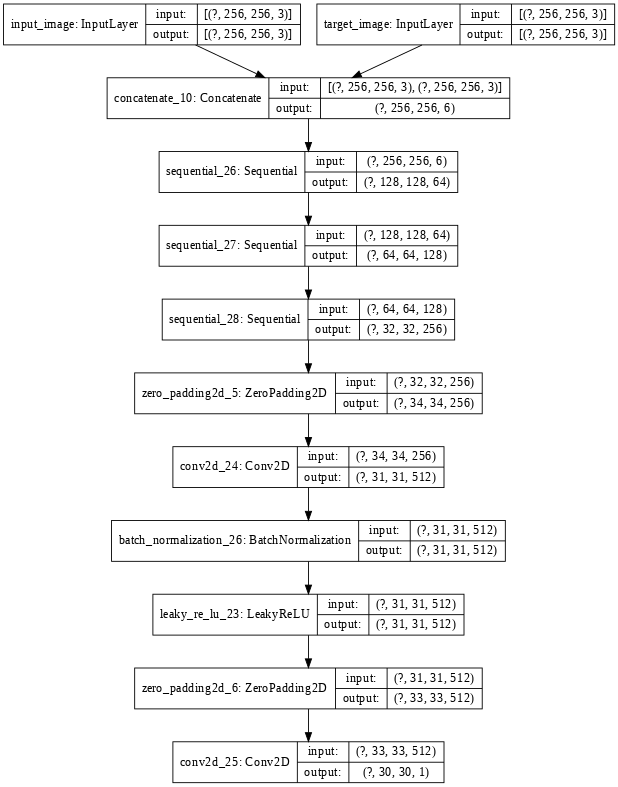

In [ ]:
def Discriminator():
    init = tf.random_uniform_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])

    down1 = gendisc_downunit(64, 4, False)(x)
    down2 = gendisc_downunit(128, 4)(down1)
    down3 = gendisc_downunit(256, 4)(down2)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(zero_pad1)

    batch_norm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=init)(zero_pad2)

    model = tf.keras.Model(inputs=[inp, tar], outputs=last)

    return model

discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

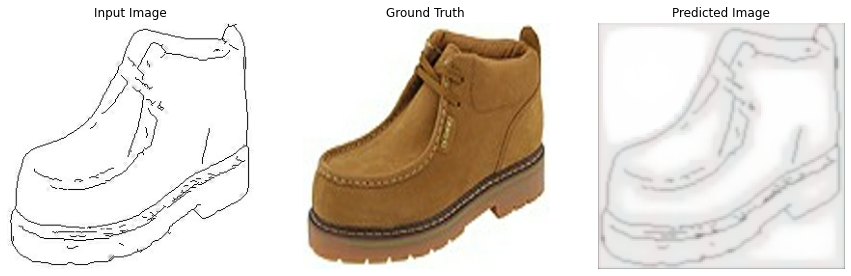

In [ ]:
def generate_images(model, test_input, tar):  
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [ ]:
EPOCHS = 1

import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 20 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

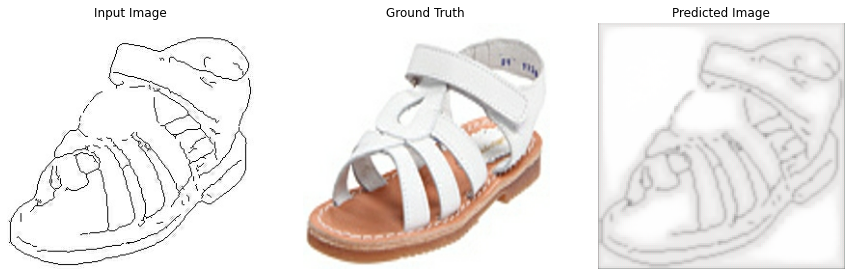

Epoch:  0
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
....................
...

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import load
from numpy import expand_dims
from matplotlib import pyplot


# load an image
def load_image(filename, size=(256,256)):
	# load image with the preferred size
	pixels = load_img(filename, target_size=size)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# scale from [0,255] to [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels
 
# load source image
src_image = load_image('satellite.jpg')
print('Loaded', src_image.shape)
# load model
model = load_model('model_109600.h5')
# generate image from source
gen_image = model.predict(src_image)
# scale from [-1,1] to [0,1]
gen_image = (gen_image + 1) / 2.0
# plot the image
pyplot.imshow(gen_image[0])
pyplot.axis('off')
pyplot.show()